### RESULTS:

##### RGB 
- means = array([74.90059245, 85.25801497, 80.06076522])
- stdevs = array([15.05452957, 13.87736375, 12.01005956])

##### DEM 
- means = array([608.951834])
- stdevs = array([2.30201424])


##### HS 
- means = array([179.17519397])
- stdevs = array([10.65291866])

### CODE FOR CALCULATING DATASET-WIDE MEAN AND STD 

In [7]:
#######
# RGB #
#######

import os
import rasterio 
import numpy as np

dir = "/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_dataset/rgb/"
all_rgb = os.listdir(dir)
all_rgb = [file for file in all_rgb if not file.endswith('aug.tif')]

img_means_sum = np.array([0.0,0.0,0.0])
img_std_sum = np.array([0.0,0.0,0.0])


for img in all_rgb:
    with rasterio.open(os.path.join(dir, img)) as img:
        img = img.read()
    img_means_sum += img.mean(axis=(1,2))
    img_std_sum += img.std(axis=(1,2))


means = img_means_sum / len(all_rgb)
stds = img_std_sum / len(all_rgb)

In [8]:
means

array([74.90059245, 85.25801497, 80.06076522])

In [9]:
stds

array([15.05452957, 13.87736375, 12.01005956])

In [10]:
##########
# dem #
##########

import os
import rasterio 
import numpy as np

dir = "/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_dataset/dem/"
all_rgb = os.listdir(dir)
all_rgb = [file for file in all_rgb if not file.endswith('aug.tif')]

img_means_sum = np.array([0.0])
img_std_sum = np.array([0.0])


for img in all_rgb:
    with rasterio.open(os.path.join(dir, img)) as img:
        img = img.read()
    img_means_sum += img.mean()
    img_std_sum += img.std()

dem_means = img_means_sum / len(all_rgb)
dem_stds = img_std_sum / len(all_rgb)

In [12]:
dem_stds

array([2.30201424])

In [13]:
##########
# hs #
##########

import os
import rasterio 
import numpy as np

dir = "/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_dataset/hs/"
all_rgb = os.listdir(dir)
all_rgb = [file for file in all_rgb if not file.endswith('aug.tif')]

img_means_sum = np.array([0.0])
img_std_sum = np.array([0.0])


for img in all_rgb:
    with rasterio.open(os.path.join(dir, img)) as img:
        img = img.read()
    img_means_sum += img.mean()
    img_std_sum += img.std()

hs_means = img_means_sum / len(all_rgb)
hs_stds = img_std_sum / len(all_rgb)

In [14]:
hs_means

array([179.17519397])

In [15]:
hs_stds

array([10.65291866])

### Testing pseudomask generation 

In [1]:
import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from utils import ImageDataset, TestSet, filter_dataset, imshow_transform
from custom_model import model_4D
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import wandb
import matplotlib.pyplot as plt 
import torch.optim.lr_scheduler as lr_scheduler
import torchmetrics
import json
from pseudomask import Pseudomasks, PseudomaskEval

train_accuracy,0.94887
train_loss,0.28536
val_accuracy,0.9425
val_loss,0.26754


wandb:   1 of 1 files downloaded.  


tensor(1.8240)


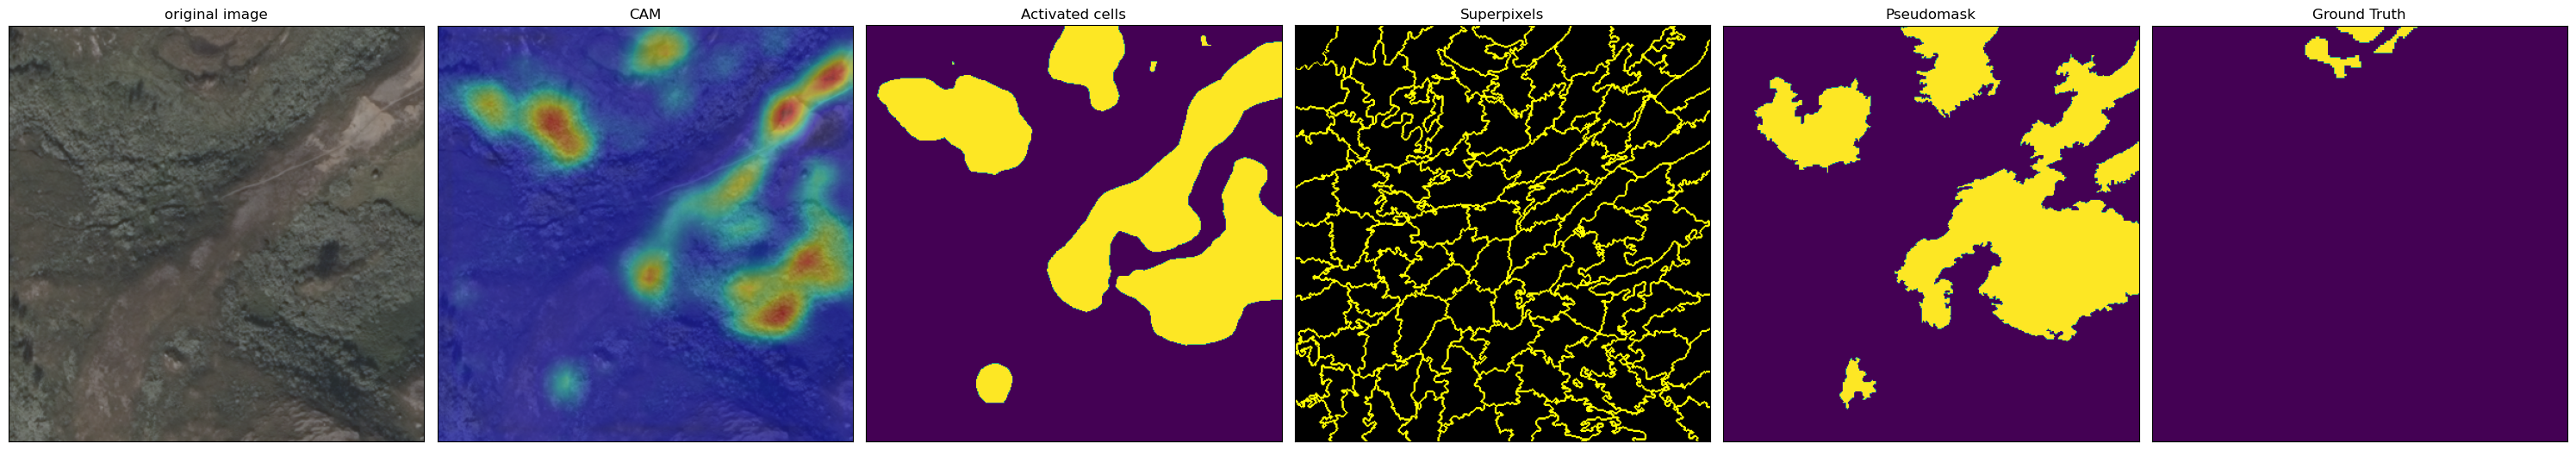

In [4]:
test_set = TestSet('hs', "/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_groundtruths", False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)
eval = PseudomaskEval()

pseudomask_generator = Pseudomasks(
                            cam_threshold_factor = 0.5, 
                            overlap_threshold= 0.5,
                            snic_seeds = 100,
                            snic_compactness = 10)

pseudomask_generator.model_from_artifact('3493djxg', artifact='v31')

for i in range(10):
    im, lab, gt_mask = next(iter(test_loader))

    # currently not yet comparing negative samples 
    if not lab == 0:
        pseudomask= pseudomask_generator.forward(im, gt_mask)

        # calculate metrics to evaluate model on test set
        generated_mask = torch.Tensor(pseudomask).float().view(400,400)
        groundtruth_mask = torch.Tensor(gt_mask).float().view(400,400)
        metrics = eval.calc_metrics(generated_mask, groundtruth_mask)


In [2]:
test_set = TestSet('hs', "/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_groundtruths", False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)

pseudomask_generator = Pseudomasks(
                            cam_threshold_factor = 0.9, 
                            overlap_threshold= 0.5,
                            snic_seeds = 100,
                            snic_compactness = 10)

pseudomask_generator.model_from_artifact('3493djxg', artifact='v31')



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


tensor(1.5559)


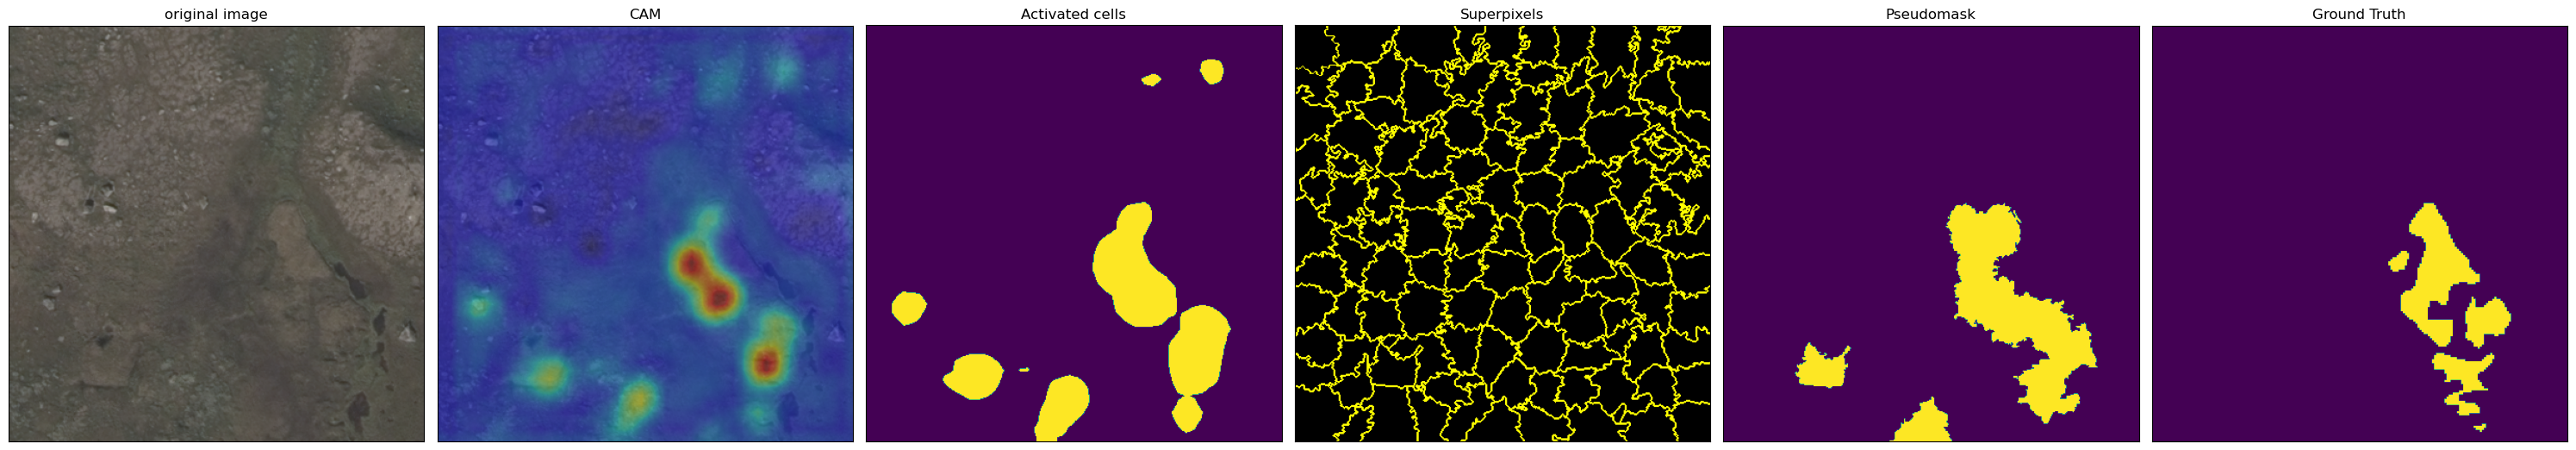

In [39]:
for i in range(1):
    im, lab, gt_mask = next(iter(test_loader))
    if not lab == 0:
        pseudomask= pseudomask_generator.forward(im, gt_mask)

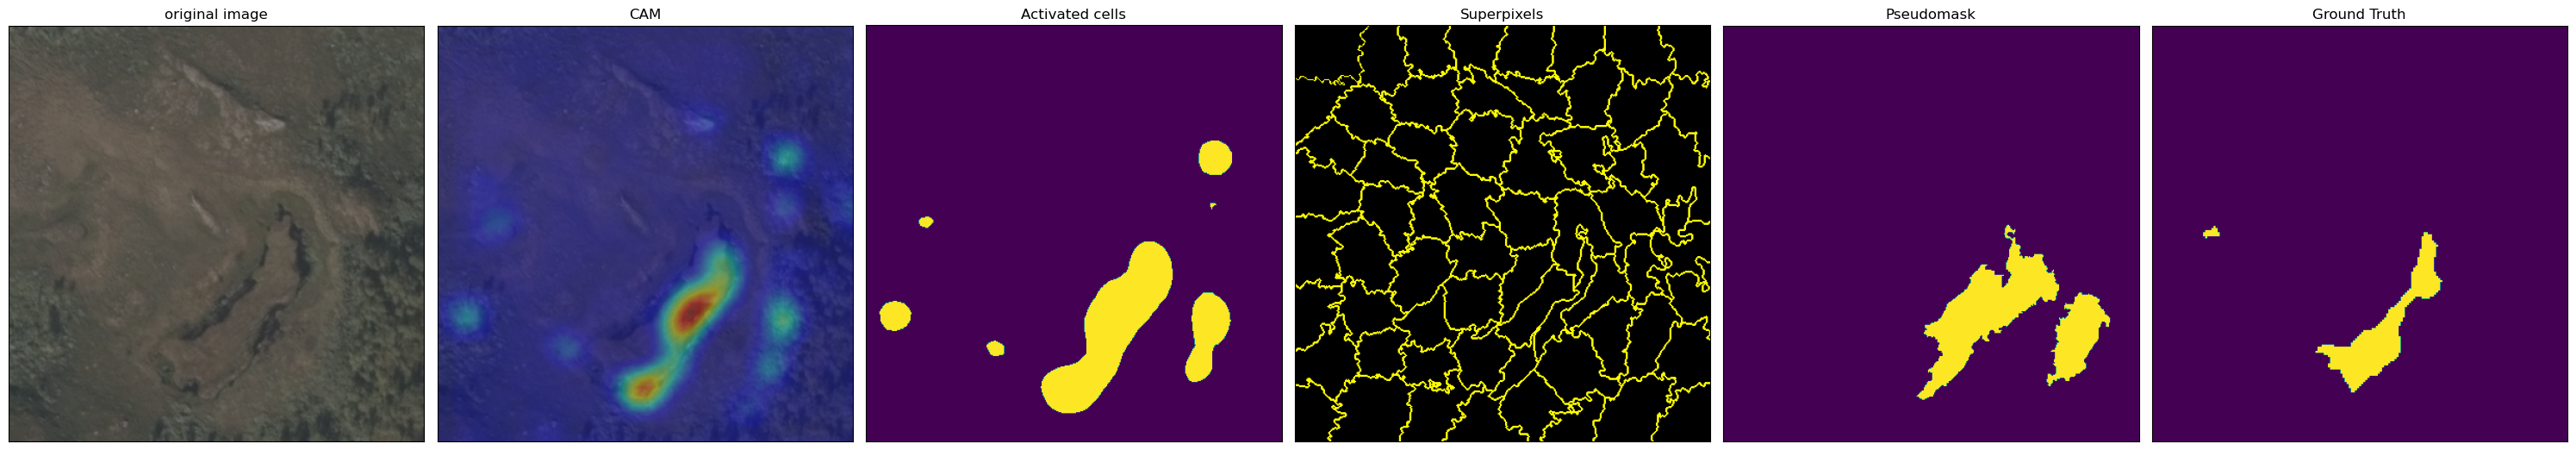

In [20]:
pseudomask= pseudomask_generator.forward(im, gt_mask)

In [ ]:
pals_acts = torch.nn.functional.interpolate(
                                    arr[:,1,:,:].unsqueeze(1), 
                                    scale_factor = im.shape[3]/arr.shape[3], 
                                mode='bilinear').cpu().detach()

In [3]:
import torch 

rand = torch.rand(2,4,400,400)

pals_acts = torch.nn.functional.interpolate(
                                    rand[:,1,:,:].unsqueeze(1), 
                                    scale_factor = 2, 
                                    mode='bilinear')

In [4]:
pals_acts.shape

torch.Size([2, 1, 800, 800])

In [7]:
activation = (pals_acts.mean(dim=(-1,-2)) + pals_acts.std(dim=(-1,-2))) * 2

In [8]:
activation

tensor([[1.3598],
        [1.3608]])

In [9]:
activation = (pals_acts.mean() + pals_acts.std()) * 2

In [10]:
activation

tensor(1.3603)